# Continuous-Time Discrete Diffusion Models

In [1]:
import os
import sys
# adding project directory to path, this is a bit hacky and may not work for all
sys.path.insert(0, os.path.abspath(os.path.dirname(os.path.abspath(''))))
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from config import rootdir
import numpy as np
import matplotlib.pyplot as plt
from kbgen.diffusion import DiscreteDiffusion, DenoisingModel, EncDec

ModuleNotFoundError: No module named 'config'

In [65]:
dm = DiscreteDiffusion(DenoisingModel(784, 32, 256, 3), EncDec())

train_data = MNIST(root=os.path.join(rootdir, "data"), train=True, download=True, transform=transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).to("cuda")))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dm.model = dm.model.to("cuda")

In [78]:
# load state_dict
device = "cuda"
dm.model.load_state_dict(torch.load(os.path.join(rootdir, "models/dm.pt")))
dm.model.eval()
dm.model.to(device)
x, y = next(iter(train_loader))
print(dm.loss(x)) 

tensor(0.2257, device='cuda:0', grad_fn=<MulBackward0>)


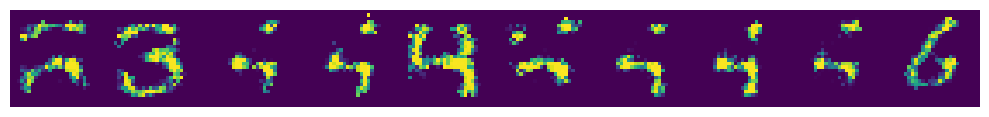

In [99]:
os.makedirs("images", exist_ok=True)
def make_samples(undo, seed=None):
    torch.manual_seed(seed)
    samples = dm.generate_sample(n:=10, leaps=1, device=device, undo=undo)
    fig, axs = plt.subplots(1, n, figsize=(n, 10))
    for i, sample in enumerate(samples):
        axs[i].imshow(sample.cpu().numpy().reshape(28, 28))
        axs[i].axis("off")
    plt.tight_layout(h_pad=0, w_pad=0)

make_samples(undo=True, seed=2)

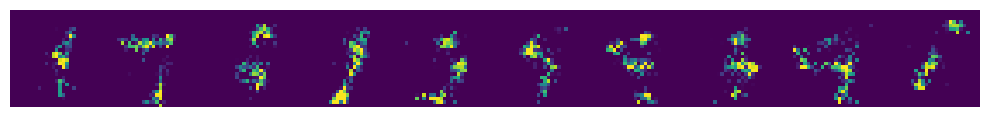

In [98]:
make_samples(undo=False, seed=42)

Text(0, 0.5, '"Class" Probability')

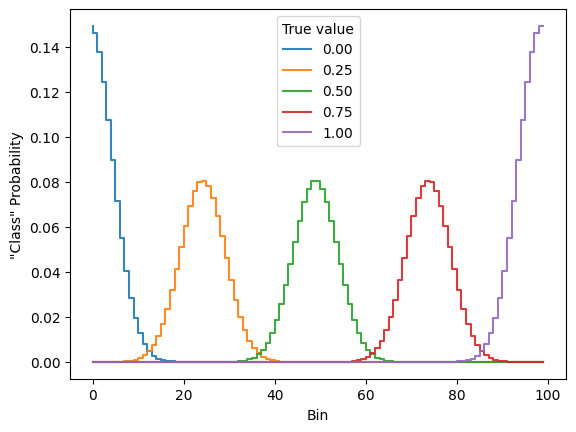

In [93]:
from torch import nn


class BinnedNumericalEmbedding(nn.Module):
    def __init__(self, num_bins)-> None:
        super().__init__()
        self.num_bins = num_bins
        self.register_buffer("bins", torch.linspace(0, 1, num_bins).float())

    def forward(self, x, stdev=0.05):
        # x is (batch, input_dim) from 0 to 1
        # returns logits for each bin
        return -(x.unsqueeze(-1) - self.bins).pow(2) / (2 * stdev**2)



bins = 100
bne = BinnedNumericalEmbedding(bins)
x = torch.linspace(0, 1, 5)
y = torch.softmax(bne(x), -1).detach()
for row, val in zip(y, x):
    plt.step(np.arange(bins), row.cpu().numpy(), alpha=0.9, label=f"{val:.2f}")
plt.legend(title="True value")
plt.xlabel("Bin")
plt.ylabel("\"Class\" Probability")